<a href="https://colab.research.google.com/github/aashmauprety/Machine-Learning/blob/master/FL_VANET_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import cv2
import os

from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, average_precision_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K


import matplotlib.pyplot as plt


In [ ]:
from google.colab import files 
uploaded = files.upload()

In [58]:
!unrar x "/content/data.rar" 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/data.rar

Extracting  Attack4.csv                                                    6%  OK 
Extracting  Attack8.csv                                                   11%  OK 
Extracting  Attack16.csv                                                  16%  OK 
Extracting  allattack.csv                                                 89%  OK 
Extracting  Attack1.csv                                                   94%  OK 
Extracting  Attack2.csv                                                   99%  OK 
All OK


In [4]:
import pandas as pd
import numpy as np

In [5]:
dataset = pd.read_csv("Finaldata1.csv")

In [6]:

X = dataset.iloc[:,:6].values
y = dataset.iloc[:,6:7].values

In [8]:
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [9]:
lb = LabelBinarizer()
y = lb.fit_transform(y)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=109)

In [11]:
print(y[0])

[1 0 0 0 0 0]


In [12]:
print(len(y))

157879


In [13]:
def create_clients(X, y, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(X, y))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [14]:
#create clients
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [15]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object of it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [16]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    # print("aashma")
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [17]:
print(clients_batched['client_1'])

<BatchDataset shapes: ((None, 6), (None, 6)), types: (tf.float64, tf.int32)>


In [105]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dropout(0.2, input_shape=(6,)))
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("sigmoid"))
        return model

In [106]:
lr = 0.01 
comms_round = 20
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / 10,
                momentum = 0.9
               )            

In [107]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count

In [108]:
def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

In [109]:
def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

In [110]:
def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('Communication Round: {} | acc: {:.3%} | loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [111]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(6, 6)

global_acc_list = []
global_loss_list = []
global_precision_list = []
#commence global training loop
for comm_round in range(comms_round):
    
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(6, 6)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        # print(len(clients_batched[client]))
        #fit local model with client's data
        # checkpoint_filepath = '/content/sample_data/model.h5'
        # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        # filepath=checkpoint_filepath,
        # save_weights_only=True,
        # monitor='val_acc',
        # mode='max',
        # save_best_only=True)


        local_model.fit(clients_batched[client], epochs=2, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    model_json = global_model.to_json()
    with open("global_model.json", "w") as json_file:
      json_file.write(model_json)
    # serialize weights to HDF5
    print("Saved model to disk")
    global_model.save_weights("model.h5")

   
    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)
        y_pred = global_model.predict(X_test)
        global_precision = precision_score(tf.argmax(y_pred, axis=1), tf.argmax(Y_test, axis=1), average='weighted')
        global_precision_list.append(global_precision)
        

Saved model to disk
Communication Round: 0 | acc: 87.364% | loss: 1.2347651720046997
Saved model to disk
Communication Round: 1 | acc: 87.465% | loss: 1.237684965133667
Saved model to disk
Communication Round: 2 | acc: 87.459% | loss: 1.2395461797714233
Saved model to disk
Communication Round: 3 | acc: 87.465% | loss: 1.2405999898910522
Saved model to disk
Communication Round: 4 | acc: 87.484% | loss: 1.2414370775222778
Saved model to disk
Communication Round: 5 | acc: 87.484% | loss: 1.2419508695602417
Saved model to disk
Communication Round: 6 | acc: 87.484% | loss: 1.2424472570419312
Saved model to disk
Communication Round: 7 | acc: 87.478% | loss: 1.242926001548767
Saved model to disk
Communication Round: 8 | acc: 87.478% | loss: 1.2432820796966553
Saved model to disk
Communication Round: 9 | acc: 87.484% | loss: 1.2436187267303467
Saved model to disk
Communication Round: 10 | acc: 87.484% | loss: 1.2438689470291138
Saved model to disk
Communication Round: 11 | acc: 87.484% | loss:

In [95]:
y_pred = global_model.predict(X_test)
# Model Precision: what percentage of positives are labeled as such?
print("Precision:",precision_score(tf.argmax(y_pred, axis=1), tf.argmax(y_test, axis=1), average='weighted'))
# print("MAP", average_precision_score(tf.argmax(y_pred, axis=1), tf.argmax(Y_test, axis=1), average='macro', pos_label=1, sample_weight=None))
global_prec= np.array(global_precision_list)
global_acc = np.array(global_acc_list)
print(global_prec)
print(global_acc)



Precision: 0.9694170937798399
[0.9678234  0.96871298 0.9690682  0.96924173 0.9692416  0.9692416
 0.96928979 0.96935855 0.96941709 0.96941709]
[0.87167469 0.87256144 0.87294147 0.87313149 0.87313149 0.87313149
 0.87319483 0.87325817 0.87332151 0.87332151]


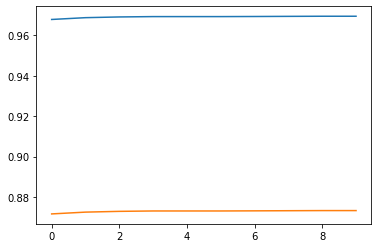

In [96]:
plt.plot(global_prec)
plt.plot(global_acc)


In [56]:
# # precision recall curve
# precision = dict()
# recall = dict()
# for i in range(6):
#     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
#     print(recall[i])
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.legend(loc="best")
# plt.title("precision vs. recall curve")
# plt.show()

In [94]:
attack1 = pd.read_csv("Attack1.csv")
X1 = attack1.iloc[:,:6].values
y1 = attack1.iloc[:,6:7].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X1 = sc.fit_transform(X1)
lb = LabelBinarizer()
y1 = lb.fit_transform(y1)
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train1,y_test1 = train_test_split(X1,y1,test_size=0.1,random_state=109)
y1_pred = global_model.predict(X_test1)




attack2 = pd.read_csv("Attack2.csv")
X2 = attack1.iloc[:,:6].values
y2 = attack1.iloc[:,6:7].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X2 = sc.fit_transform(X2)
lb = LabelBinarizer()
y2 = lb.fit_transform(y2)
from sklearn.model_selection import train_test_split
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.1,random_state=109)
y2_pred = global_model.predict(X_test2)





attack4 = pd.read_csv("Attack4.csv")
X4 = attack1.iloc[:,:6].values
y4 = attack1.iloc[:,6:7].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X4 = sc.fit_transform(X4)
lb = LabelBinarizer()
y4 = lb.fit_transform(y4)
from sklearn.model_selection import train_test_split
X_train4,X_test4,y_train4,y_test4 = train_test_split(X4,y4,test_size=0.1,random_state=109)
y4_pred = global_model.predict(X_test4)





attack8 = pd.read_csv("Attack8.csv")
X8 = attack1.iloc[:,:6].values
y8 = attack1.iloc[:,6:7].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X8 = sc.fit_transform(X8)
lb = LabelBinarizer()
y8 = lb.fit_transform(y8)
from sklearn.model_selection import train_test_split
X_train8,X_test8,y_train8,y_test8 = train_test_split(X8,y8,test_size=0.1,random_state=109)
y8_pred = global_model.predict(X_test8)



attack16 = pd.read_csv("Attack16.csv")
X16 = attack1.iloc[:,:6].values
y16 = attack1.iloc[:,6:7].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X16 = sc.fit_transform(X16)
lb = LabelBinarizer()
y16 = lb.fit_transform(y16)
from sklearn.model_selection import train_test_split
X_train16,X_test16,y_train16,y_test16 = train_test_split(X16,y16,test_size=0.1,random_state=109)
y16_pred = global_model.predict(X_test16)


print("Precision for Attack 1:",precision_score(tf.argmax(y1_pred, axis=1), tf.argmax(y_test1, axis=1), average='weighted'))
print("Precision for Attack 2:",precision_score(tf.argmax(y2_pred, axis=1), tf.argmax(y_test2, axis=1), average='weighted'))
print("Precision for Attack 4:",precision_score(tf.argmax(y4_pred, axis=1), tf.argmax(y_test4, axis=1), average='weighted'))
print("Precision for Attack 8:",precision_score(tf.argmax(y8_pred, axis=1), tf.argmax(y_test8, axis=1), average='weighted'))
print("Precision for Attack 16:",precision_score(tf.argmax(y16_pred, axis=1), tf.argmax(y_test16, axis=1), average='weighted'))

# print("MAP", average_precision_score(tf.argmax(y_pred, axis=1), tf.argmax(Y_test, axis=1), average='macro', pos_label=1, sample_weight=None))
global_prec= np.array(global_precision_list)
print(f"Precision for each round: {global_prec}")

Precision for Attack 1: 0.7547661476180705
Precision for Attack 2: 0.7547661476180705
Precision for Attack 4: 0.7547661476180705
Precision for Attack 8: 0.7547661476180705
Precision for Attack 16: 0.7547661476180705
Precision for each round: [0.9678234  0.96871298 0.9690682  0.96924173 0.9692416  0.9692416
 0.96928979 0.96935855 0.96941709 0.96941709]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
